In [11]:
%load_ext autoreload
%autoreload 2
%run ../src/notebook_env.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# import sys
# sys.path.append('/home/jcejudo/rd-img-classification-pilot/src')
from torch_utils import *
from ds_utils import *
from gradcam import *
from models import *
import torch


In [102]:

train_info_path = '/home/jcejudo/rd-img-classification-pilot/results/ec_getty/split_0/training_info.pth'
training_info = torch.load(train_info_path)
encoding_dict = training_info['encoding_dict']
print(encoding_dict)

{0: 'archaeological_site', 1: 'building', 2: 'ceramics', 3: 'clothing', 4: 'costume_accessories', 5: 'drawing', 6: 'furniture', 7: 'inscription', 8: 'jewellery', 9: 'map', 10: 'painting', 11: 'photograph', 12: 'postcard', 13: 'sculpture', 14: 'specimen', 15: 'tapestry', 16: 'textile', 17: 'toy', 18: 'weaponry', 19: 'woodwork'}


In [32]:
device, _ = check_cuda()
model_path = '/home/jcejudo/rd-img-classification-pilot/results/ec_getty/split_0/checkpoint.pth'

model = ResNet(34,20)
model.load_state_dict(torch.load(model_path))
model.eval()


Using a single device 



ResNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [19]:
print(model)

ResNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [33]:
#get data
data_path = '/home/jcejudo/rd-img-classification-pilot/training_data/ec'
ec_df = path2DataFrame(data_path)

data_path = '/home/jcejudo/rd-img-classification-pilot/training_data/getty'
getty_df = path2DataFrame(data_path)

df = pd.concat((ec_df,getty_df))

furniture
furniture


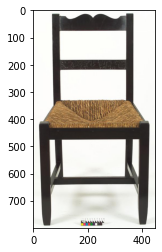

woodwork
woodwork


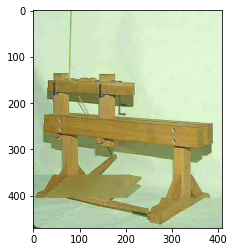

inscription
inscription


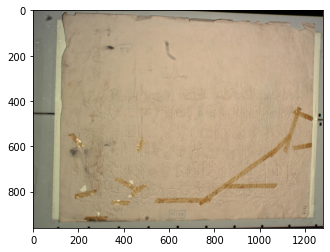

map
building


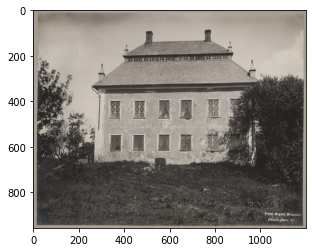

costume_accessories
costume_accessories


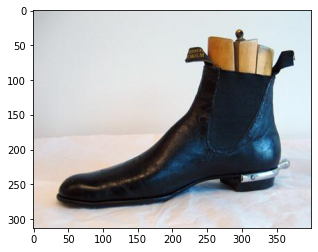

archaeological_site
archaeological_site


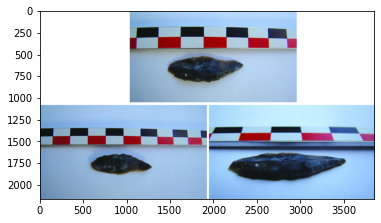

photograph
photograph


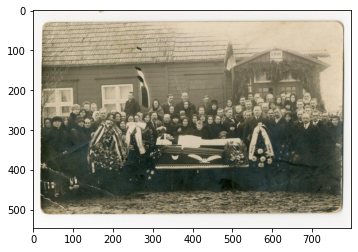

drawing
drawing


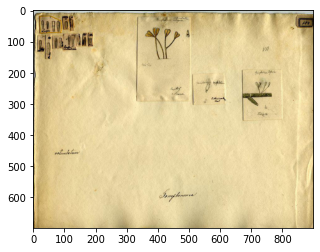

archaeological_site
archaeological_site


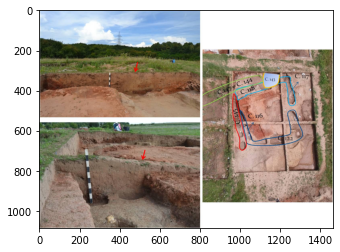

painting
painting


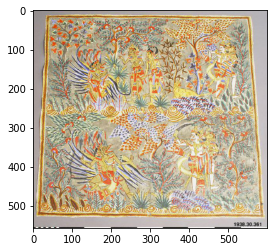

In [35]:
from matplotlib.pyplot import imshow

transform = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

_df = df.sample(frac=0.1)
for i in range(10):
    file_path = _df['file_path'].iloc[i]
    cat = _df['category'].iloc[i]
    print(cat)
    
    #print(file_path)
    image = Image.open(file_path).convert('RGB')
#     with torch.no_grad():

    input_tensor = transform(image)
    output = model(input_tensor.unsqueeze(0))[0]
    pred = encoding_dict[torch.argmax(output).item()]
    
    print(pred)



    
    imshow(image)
    plt.show()

    
    
    

In [36]:
import random



In [51]:
import cv2
import torch
import numpy as np
from PIL import Image

class InfoHolder():

    def __init__(self, heatmap_layer):
        self.gradient = None
        self.activation = None
        self.heatmap_layer = heatmap_layer

    def get_gradient(self, grad):
        self.gradient = grad

    def hook(self, model, input, output):
        output.register_hook(self.get_gradient)
        self.activation = output.detach()

def generate_heatmap(weighted_activation):
    raw_heatmap = torch.mean(weighted_activation, 0)
    heatmap = np.maximum(raw_heatmap.detach().cpu(), 0)
    heatmap /= torch.max(heatmap) + 1e-10
    return heatmap.numpy()

def superimpose(input_img, heatmap):
    img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * 0.6 + img * 0.4)
    pil_img = cv2.cvtColor(superimposed_img,cv2.COLOR_BGR2RGB)
    return pil_img

def to_RGB(tensor):
    tensor = (tensor - tensor.min())
    tensor = tensor/(tensor.max() + 1e-10)
    image_binary = np.transpose(tensor.numpy(), (1, 2, 0))
    image = np.uint8(255 * image_binary)
    return image

def grad_cam(model, image, heatmap_layer, transform, truelabel=None):
    
    input_tensor = transform(image)
    #input_tensor = input_tensor.to(device)
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)
    output = model(input_tensor.unsqueeze(0))[0]
    
    truelabel = truelabel if truelabel else torch.argmax(output)
    print(encoding_dict[truelabel.item()])
    
    
    output[truelabel].backward()
    weights = torch.mean(info.gradient, [0, 2, 3])
    activation = info.activation.squeeze(0)
    weighted_activation = torch.zeros(activation.shape)
    for idx, (weight, activation) in enumerate(zip(weights, activation)):
        weighted_activation[idx] = weight * activation

    heatmap = generate_heatmap(weighted_activation)
    #print(heatmap)
    #image = Image.open(img_path).convert('RGB')
    
    return superimpose(np.asarray(image),heatmap)

tapestry
tapestry


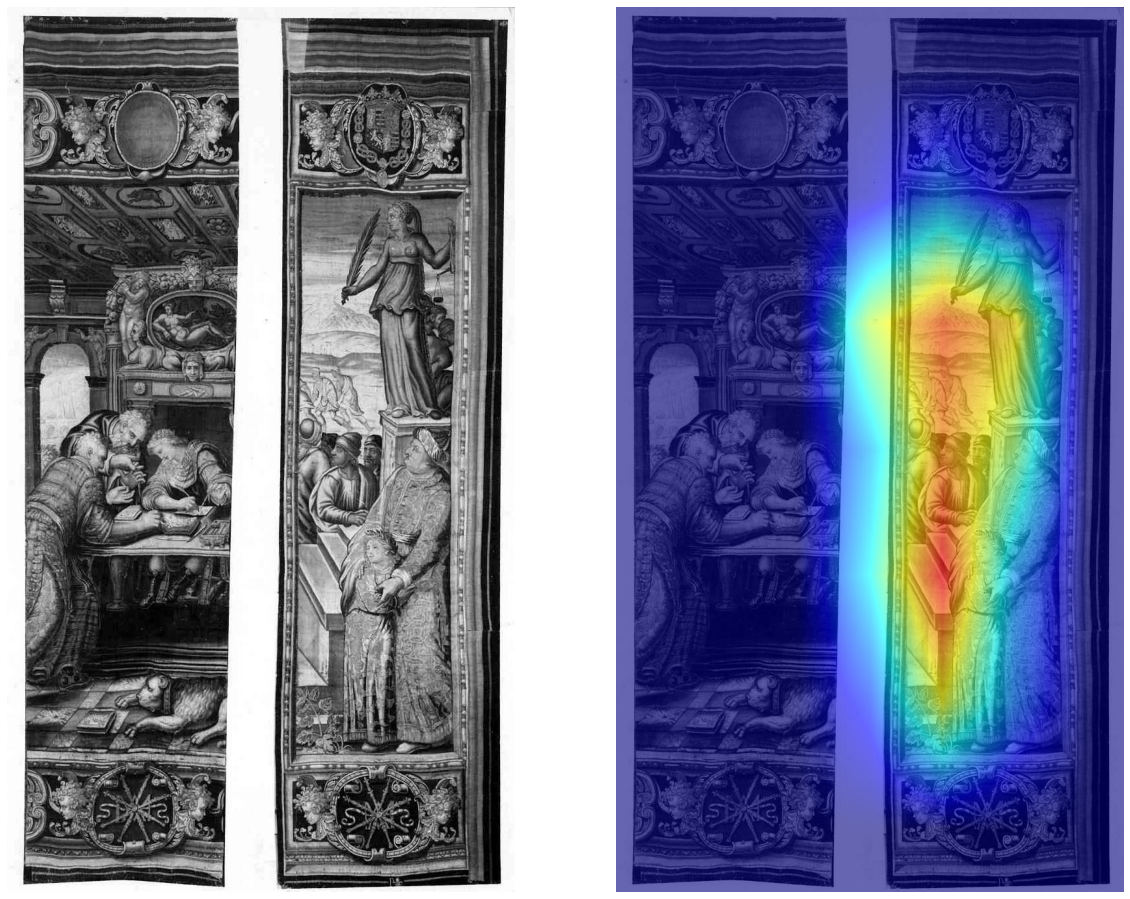

In [101]:
idx = random.randrange(df.shape[0])

img_path = df['file_path'].iloc[idx]

print(df['category'].iloc[idx])
#load img
image = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

heatmap_layer = model.net.layer4[1].conv2
#print(heatmap_layer)
image_interpretable = grad_cam(model, image, heatmap_layer, transform)

fig,ax = plt.subplots(1,2,figsize=(20,20))

ax[0].imshow(image)
#ax[0].set_title('input',fontsize=25)
ax[0].axis('off')

ax[1].imshow(image_interpretable)
#ax[1].set_title('input',fontsize=25)
ax[1].axis('off')

XAI_img = Image.fromarray(image_interpretable).convert('RGB')

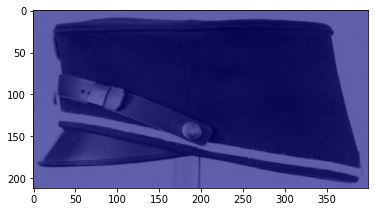

In [106]:
from matplotlib.pyplot import imshow
imshow(XAI_img)

RuntimeError: Error(s) in loading state_dict for ResNet:
	Unexpected key(s) in state_dict: "net.layer1.2.conv1.weight", "net.layer1.2.bn1.weight", "net.layer1.2.bn1.bias", "net.layer1.2.bn1.running_mean", "net.layer1.2.bn1.running_var", "net.layer1.2.bn1.num_batches_tracked", "net.layer1.2.conv2.weight", "net.layer1.2.bn2.weight", "net.layer1.2.bn2.bias", "net.layer1.2.bn2.running_mean", "net.layer1.2.bn2.running_var", "net.layer1.2.bn2.num_batches_tracked", "net.layer2.2.conv1.weight", "net.layer2.2.bn1.weight", "net.layer2.2.bn1.bias", "net.layer2.2.bn1.running_mean", "net.layer2.2.bn1.running_var", "net.layer2.2.bn1.num_batches_tracked", "net.layer2.2.conv2.weight", "net.layer2.2.bn2.weight", "net.layer2.2.bn2.bias", "net.layer2.2.bn2.running_mean", "net.layer2.2.bn2.running_var", "net.layer2.2.bn2.num_batches_tracked", "net.layer2.3.conv1.weight", "net.layer2.3.bn1.weight", "net.layer2.3.bn1.bias", "net.layer2.3.bn1.running_mean", "net.layer2.3.bn1.running_var", "net.layer2.3.bn1.num_batches_tracked", "net.layer2.3.conv2.weight", "net.layer2.3.bn2.weight", "net.layer2.3.bn2.bias", "net.layer2.3.bn2.running_mean", "net.layer2.3.bn2.running_var", "net.layer2.3.bn2.num_batches_tracked", "net.layer3.2.conv1.weight", "net.layer3.2.bn1.weight", "net.layer3.2.bn1.bias", "net.layer3.2.bn1.running_mean", "net.layer3.2.bn1.running_var", "net.layer3.2.bn1.num_batches_tracked", "net.layer3.2.conv2.weight", "net.layer3.2.bn2.weight", "net.layer3.2.bn2.bias", "net.layer3.2.bn2.running_mean", "net.layer3.2.bn2.running_var", "net.layer3.2.bn2.num_batches_tracked", "net.layer3.3.conv1.weight", "net.layer3.3.bn1.weight", "net.layer3.3.bn1.bias", "net.layer3.3.bn1.running_mean", "net.layer3.3.bn1.running_var", "net.layer3.3.bn1.num_batches_tracked", "net.layer3.3.conv2.weight", "net.layer3.3.bn2.weight", "net.layer3.3.bn2.bias", "net.layer3.3.bn2.running_mean", "net.layer3.3.bn2.running_var", "net.layer3.3.bn2.num_batches_tracked", "net.layer3.4.conv1.weight", "net.layer3.4.bn1.weight", "net.layer3.4.bn1.bias", "net.layer3.4.bn1.running_mean", "net.layer3.4.bn1.running_var", "net.layer3.4.bn1.num_batches_tracked", "net.layer3.4.conv2.weight", "net.layer3.4.bn2.weight", "net.layer3.4.bn2.bias", "net.layer3.4.bn2.running_mean", "net.layer3.4.bn2.running_var", "net.layer3.4.bn2.num_batches_tracked", "net.layer3.5.conv1.weight", "net.layer3.5.bn1.weight", "net.layer3.5.bn1.bias", "net.layer3.5.bn1.running_mean", "net.layer3.5.bn1.running_var", "net.layer3.5.bn1.num_batches_tracked", "net.layer3.5.conv2.weight", "net.layer3.5.bn2.weight", "net.layer3.5.bn2.bias", "net.layer3.5.bn2.running_mean", "net.layer3.5.bn2.running_var", "net.layer3.5.bn2.num_batches_tracked", "net.layer4.2.conv1.weight", "net.layer4.2.bn1.weight", "net.layer4.2.bn1.bias", "net.layer4.2.bn1.running_mean", "net.layer4.2.bn1.running_var", "net.layer4.2.bn1.num_batches_tracked", "net.layer4.2.conv2.weight", "net.layer4.2.bn2.weight", "net.layer4.2.bn2.bias", "net.layer4.2.bn2.running_mean", "net.layer4.2.bn2.running_var", "net.layer4.2.bn2.num_batches_tracked". 

In [16]:
torch.load(model_path)

OrderedDict([('net.conv1.weight',
              tensor([[[[ 4.9233e-03, -7.1119e-03,  7.6719e-03,  ...,  4.9213e-02,
                          3.1404e-02,  2.6288e-02],
                        [ 4.0598e-02,  3.1302e-02,  3.1818e-02,  ...,  3.3117e-02,
                          3.0269e-02,  4.2352e-02],
                        [ 4.6202e-03, -3.1677e-02, -6.1764e-02,  ..., -9.7409e-02,
                         -1.1539e-01, -1.2150e-01],
                        ...,
                        [-1.2531e-02, -2.4833e-02, -9.4924e-03,  ...,  1.7594e-02,
                          3.0361e-03,  1.7325e-02],
                        [ 3.6684e-03,  4.5494e-03,  3.6241e-02,  ...,  1.0441e-01,
                          7.4554e-02,  5.9378e-02],
                        [ 1.6537e-02,  8.8721e-03,  3.1094e-02,  ...,  9.7230e-02,
                          8.4017e-02,  9.7110e-02]],
              
                       [[-7.9569e-03, -8.7100e-03,  1.4156e-02,  ...,  3.4137e-02,
                          2.